In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import zipfile
zip_path = '/content/drive/MyDrive/archive.zip'
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
else:
    raise FileNotFoundError("файла нет")

Mounted at /content/drive


In [3]:
train_dir = '/content/dataset/asl_alphabet_train/asl_alphabet_train'
test_dir = '/content/dataset/asl_alphabet_test/asl_alphabet_test'

IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 30

In [4]:
def load_dataset(folder, img_size=(64, 64), max_per_class=None):
    images = []
    labels = []

    class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])

    print(f"кол-во классов: {len(class_names)}")

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        all_files = os.listdir(class_path)
        image_files = [f for f in all_files
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif'))]
        if max_per_class and len(image_files) > max_per_class:
            image_files = image_files[:max_per_class]

        print(f"класс '{class_name}': {len(image_files)} изображений")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(class_idx)

            except Exception as e:
                continue
    if len(images) == 0:
        return np.array([]), np.array([]), class_names
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

In [5]:
def load_test_dataset(test_dir, img_size=(64, 64)):
    images = []
    labels = []
    test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    file_to_class = {}

    for filename in test_files:
        class_name = filename.split('_')[0].upper()
        file_to_class[filename] = class_name

    for filename, class_name in file_to_class.items():
        if class_name in class_names:
            class_idx = class_names.index(class_name)
        else:
            continue

        img_path = os.path.join(test_dir, filename)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(class_idx)
        except Exception as e:
            continue

    if len(images) == 0:
        return np.array([]), np.array([])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def load_train_dataset(train_dir, img_size=(64, 64), max_per_class=300):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

    print(f"кол-во классов: {len(class_names)}")

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        all_files = os.listdir(class_path)
        image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif'))]
        if max_per_class and len(image_files) > max_per_class:
            image_files = image_files[:max_per_class]

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(class_idx)
            except Exception as e:
                continue

    if len(images) == 0:
        return np.array([]), np.array([]), []

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, class_names

In [6]:
X_train, y_train, class_names = load_train_dataset(train_dir, max_per_class=300)
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")

X_test, y_test = load_test_dataset(test_dir)
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

кол-во классов: 29
  X_train shape: (8700, 64, 64, 3)
  y_train shape: (8700,)
  X_test shape: (26, 64, 64, 3)
  y_test shape: (26,)


In [7]:
from sklearn.model_selection import train_test_split

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)
print(f"  X_train_split: {X_train_split.shape}")
print(f"  y_train_split: {y_train_split.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

if len(X_test) > 0:
    print(f"  X_test: {X_test.shape}")
    print(f"  y_test: {y_test.shape}")

y_train_cat = keras.utils.to_categorical(y_train_split, len(class_names))
y_val_cat = keras.utils.to_categorical(y_val, len(class_names))

if len(X_test) > 0:
    y_test_cat = keras.utils.to_categorical(y_test, len(class_names))

  X_train_split: (6960, 64, 64, 3)
  y_train_split: (6960,)
  X_val: (1740, 64, 64, 3)
  y_val: (1740,)
  X_test: (26, 64, 64, 3)
  y_test: (26,)


In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(
    X_train_split, y_train_cat,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_generator = val_datagen.flow(
    X_val, y_val_cat,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
def create_model(input_shape=(64, 64, 3), num_classes=29):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=len(class_names))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,415,613 (13.03 MB)

 Trainable params: 3,412,157 (13.02 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [10]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='asl_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(X_val) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.0699 - loss: 5.5787
Epoch 1: val_accuracy improved from -inf to 0.03356, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.0727 - loss: 5.5097 - val_accuracy: 0.0336 - val_loss: 9.8931 - learning_rate: 0.0010
Epoch 2/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1619 - loss: 4.4060
Epoch 2: val_accuracy improved from 0.03356 to 0.04630, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.1640 - loss: 4.3796 - val_accuracy: 0.0463 - val_loss: 7.5577 - learning_rate: 0.0010
Epoch 3/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2522 - loss: 3.7590
Epoch 3: val_accuracy improved from 0.04630 to 0.26389, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.2561 - loss: 3.7316 - val_accuracy: 0.2639 - val_loss: 3.6310 - learning_rate: 0.0010
Epoch 4/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3508 - loss: 3.2242
Epoch 4: val_accuracy improved from 0.26389 to 0.27604, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.3545 - loss: 3.2014 - val_accuracy: 0.2760 - val_loss: 3.5861 - learning_rate: 0.0010
Epoch 5/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4448 - loss: 2.7490
Epoch 5: val_accuracy improved from 0.27604 to 0.33160, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4495 - loss: 2.7257 - val_accuracy: 0.3316 - val_loss: 3.3801 - learning_rate: 0.0010
Epoch 6/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5366 - loss: 2.3307
Epoch 6: val_accuracy improved from 0.33160 to 0.60069, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5392 - loss: 2.3187 - val_accuracy: 0.6007 - val_loss: 2.0546 - learning_rate: 0.0010
Epoch 7/30
217/271 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6060 - loss: 2.0231
Epoch 7: val_accuracy improved from 0.60069 to 0.72106, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6094 - loss: 2.0071 - val_accuracy: 0.7211 - val_loss: 1.5558 - learning_rate: 0.0010
Epoch 8/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6828 - loss: 1.7205
Epoch 8: val_accuracy did not improve from 0.72106
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6824 - loss: 1.7186 - val_accuracy: 0.6262 - val_loss: 1.8442 - learning_rate: 0.0010
Epoch 9/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7128 - loss: 1.5643
Epoch 9: val_accuracy improved from 0.72106 to 0.79514, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7152 - loss: 1.5554 - val_accuracy: 0.7951 - val_loss: 1.2810 - learning_rate: 0.0010
Epoch 10/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7564 - loss: 1.4188
Epoch 10: val_accuracy did not improve from 0.79514
271/271 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7576 - loss: 1.4153 - val_accuracy: 0.6678 - val_loss: 1.7113 - learning_rate: 0.0010
Epoch 11/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7818 - loss: 1.3088
Epoch 11: val_accuracy improved from 0.79514 to 0.90509, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7825 - loss: 1.3047 - val_accuracy: 0.9051 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 12/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8148 - loss: 1.2036
Epoch 12: val_accuracy did not improve from 0.90509
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8159 - loss: 1.1998 - val_accuracy: 0.8779 - val_loss: 1.0121 - learning_rate: 0.0010
Epoch 13/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8356 - loss: 1.1190
Epoch 13: val_accuracy did not improve from 0.90509
271/271 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8356 - loss: 1.1170 - val_accuracy: 0.8096 - val_loss: 1.2275 - learning_rate: 0.0010
Epoch 14/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8352 - loss: 1.1313
Epoch 14: val_accuracy improved from 0.90509 to 0.93981, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8365 - loss: 1.1272 - val_accuracy: 0.9398 - val_loss: 0.8163 - learning_rate: 0.0010
Epoch 15/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8619 - loss: 1.0383
Epoch 15: val_accuracy did not improve from 0.93981
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8609 - loss: 1.0398 - val_accuracy: 0.8293 - val_loss: 1.1341 - learning_rate: 0.0010
Epoch 16/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8691 - loss: 1.0037
Epoch 16: val_accuracy did not improve from 0.93981
271/271 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8690 - loss: 1.0033 - val_accuracy: 0.8924 - val_loss: 0.9233 - learning_rate: 0.0010
Epoch 17/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8598 - loss: 1.0369
Epoch 17: val_accuracy did not improve from 0.93981
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8614 - loss: 1.0323 - val_accuracy: 0.8356 - val_loss: 1.1122 - learning_rate: 0.0010
Epoch 18

271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8964 - loss: 0.9210 - val_accuracy: 0.9468 - val_loss: 0.7395 - learning_rate: 0.0010
Epoch 19/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8863 - loss: 0.9362
Epoch 19: val_accuracy did not improve from 0.94676
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8860 - loss: 0.9360 - val_accuracy: 0.8889 - val_loss: 0.9347 - learning_rate: 0.0010
Epoch 20/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8801 - loss: 0.9783
Epoch 20: val_accuracy did not improve from 0.94676
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8823 - loss: 0.9718 - val_accuracy: 0.9207 - val_loss: 0.8447 - learning_rate: 0.0010
Epoch 21/30
217/271 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9054 - loss: 0.8817
Epoch 21: val_accuracy did not improve from 0.94676
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9055 - loss: 0.8797 - val_accuracy: 0.8391 - val_loss: 1.1300 - learning_rate: 0.0010
Epoch 22

271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9078 - loss: 0.8517 - val_accuracy: 0.9560 - val_loss: 0.7252 - learning_rate: 0.0010
Epoch 23/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9093 - loss: 0.8862
Epoch 23: val_accuracy did not improve from 0.95602
271/271 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9090 - loss: 0.8870 - val_accuracy: 0.9051 - val_loss: 0.9376 - learning_rate: 0.0010
Epoch 24/30
217/271 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9079 - loss: 0.8915
Epoch 24: val_accuracy improved from 0.95602 to 0.96007, saving model to asl_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.9080 - loss: 0.8910 - val_accuracy: 0.9601 - val_loss: 0.7377 - learning_rate: 0.0010
Epoch 25/30
218/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9056 - loss: 0.9046
Epoch 25: val_accuracy did not improve from 0.96007
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9059 - loss: 0.9038 - val_accuracy: 0.9589 - val_loss: 0.7170 - learning_rate: 0.0010
Epoch 26/30
217/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9101 - loss: 0.8934
Epoch 26: val_accuracy did not improve from 0.96007
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9094 - loss: 0.8948 - val_accuracy: 0.9520 - val_loss: 0.7632 - learning_rate: 0.0010
Epoch 27/30
217/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9151 - loss: 0.8718
Epoch 27: val_accuracy did not improve from 0.96007
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9156 - loss: 0.8686 - val_accuracy: 0.9352 - val_loss: 0.7834 - learning_rate: 0.0010
Epoch 28

271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9228 - loss: 0.8299 - val_accuracy: 0.9664 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 30/30
217/271 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9222 - loss: 0.8410
Epoch 30: val_accuracy did not improve from 0.96644
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9225 - loss: 0.8403 - val_accuracy: 0.8281 - val_loss: 1.1576 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 29.


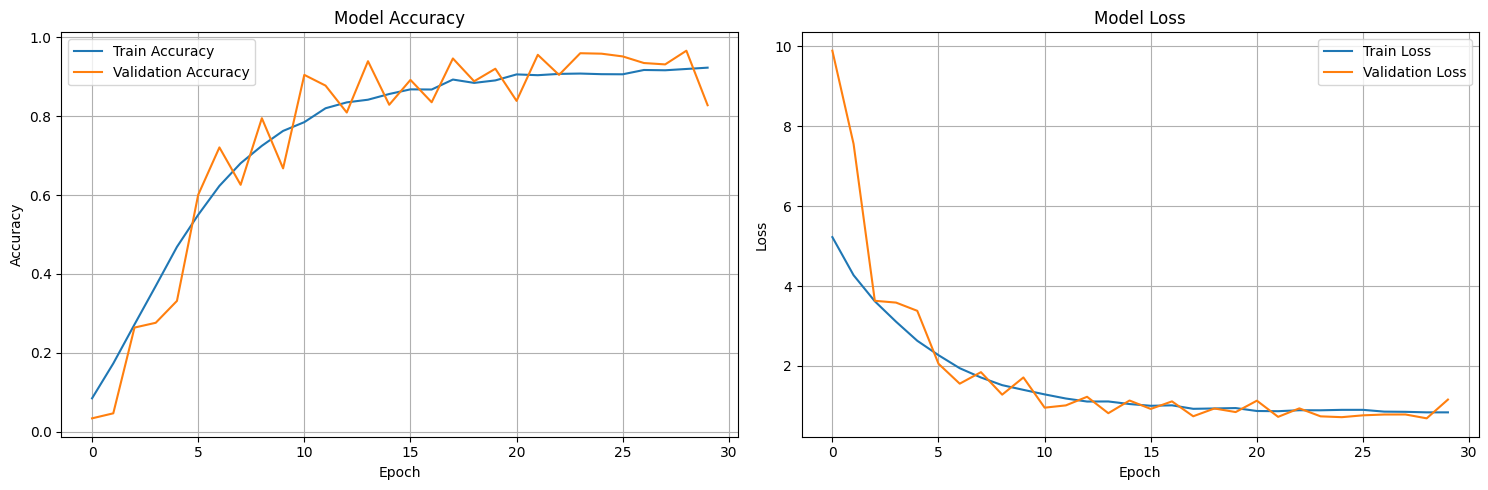

In [12]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [14]:
if len(X_test) > 0:
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test_cat shape: {y_test_cat.shape}")
    test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

X_test shape: (26, 64, 64, 3)
y_test_cat shape: (26, 29)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9615 - loss: 0.6417
Test Loss: 0.6417
Test Accuracy: 0.9615
